# **Protein Secondary Structure Prediction using Graph Neural Network**

Proteins are chains of amino acids joined together by peptide bonds . Each amino acid in the chain is polar, i.e. it has separated positive and negative charged regions with a free carbonyl group, which can act as hydrogen bond acceptor and an NH group, which can act as hydrogen bond donor. These groups can therefore interact in the protein structure. The 20 amino acids can be classified according to the chemistry of the side chain which also plays an important structural role.

The protein structure can be considered as a sequence of secondary structure elements, such as α helices, β sheets and coils, which together constitute the overall three-dimensional configuration of the protein chain.

# **Import the Library**

In [ ]:
import numpy as np                                     # linear algebra
import pandas as pd                                    # data processing, CSV file I/O (e.g. pd.read_csv)
import copy                                            #to copy list
from sklearn.model_selection import train_test_split   #to split dataset into train and test set
from sklearn.svm import SVC                            #to create svc instance
from sklearn.metrics import classification_report      #to create report for precision,recall,f1-score,accuracy
from sklearn import metrics                            #to get accuracy
from sklearn.model_selection import GridSearchCV       #to optimise the hyper-parameter
import math



# Directory of Dataset
find the directory of dataset

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load the dataset

**PDB Dataset**<br>
Load the .csv file into dataframe and see if it is load properly .

In [ ]:
#dataset 1
#df = pd.read_csv('/kaggle/input/protein-secondary-structure/2018-06-06-ss.cleaned.csv')
#dataset 2
#df = pd.read_csv('/kaggle/input/protein-secondary-sequence/PDB_31-12-2012.csv')
#dataset 3
#df = pd.read_csv('/kaggle/input/protein-secondary-sequence/PDB_31-12-2012.csv')
#dataset 4
df = pd.read_csv('../input/protein-secondary-structure-casp12-cb513-ts115/training_secondary_structure_train.csv')
#casp12
df_test1 = pd.read_csv('../input/protein-secondary-structure-casp12-cb513-ts115/test_secondary_structure_casp12.csv')

In [ ]:
#dataset 1
'''
df=df.head(5001)
df.head()
#print(df.info())
'''

In [ ]:
#dataset 2
#df=df.head()
df.head()

In [ ]:
#dataset 3
'''
df=df.head(50)
df.head()
'''

# **Data processing** 

The PDB dataset is opened and processed using the python programming language. The 'seq' column has the primary sequence of protein and the 'sst8' has the seconday sequence of protein . The max length of any sequence set to 128 . 
hasnonstdaa: whether the peptide contains nonstandard amino acids (B, O, U, X, or Z).
So those sequences are only taken which don't have nonstandard amino acids .

In [ ]:
#dataset 1
'''
maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst8']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_seqs, target_seqs = df[['seq', 'sst8']][(~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(input_seqs[0:5])
'''

In [ ]:
#dataset 2 & 3
'''
#maxlen_seq = 550
#input_seqs, target_seqs = df[['seq', 'sst8']][(df['sst8'].apply(lambda x: len(x))<= maxlen_seq)].values.T
input_seqs, target_seqs = df[['seq', 'sst8']].values.T
print(input_seqs[0:8])
'''

In [ ]:
#dataset 4
input_seqs, target_seqs = df[['seq', 'sst8']].values.T
input_seqs_test1, target_seqs_test1 = df_test1[['seq', 'sst8']].values.T

print(input_seqs[0:8])
print(input_seqs_test1[0:8])

see the target sequence(secondary structure) and it's size . 

In [ ]:
print(target_seqs[0:8])
print(target_seqs.size)

In [ ]:
inputSeqs=[]
targetSeqs=[]
for i in range(input_seqs.size):
    j=0
    while(j<len(input_seqs[i])/128):
        start = j*128
        end = start+128
        inputSeqs.append(input_seqs[i][start:end])
        targetSeqs.append(target_seqs[i][start:end])
        j+=1
        
print(len(targetSeqs))
print(len(inputSeqs))

In [ ]:
inputSeqs_test1=[]
targetSeqs_test1=[]
for i in range(input_seqs_test1.size):
    j=0
    while(j<len(input_seqs_test1[i])/128):
        start = j*128
        end = start+128
        inputSeqs_test1.append(input_seqs_test1[i][start:end])
        targetSeqs_test1.append(target_seqs_test1[i][start:end])
        j+=1
        
print(len(targetSeqs_test1))
print(len(inputSeqs_test1))

# **Looking for incomplete data**

Check the data whether there are differences in the number of characters of the primary structure and secondary structure (because the prediction of the secondary structure of the protein is included in the sequence labeling problem, it is certain that the number of characters of the primary structure and secondary structure is always the same)

In [ ]:
#for test data
for row in range(len(targetSeqs_test1)):
    secondary_lenth1 = len(targetSeqs_test1[row])
    primary_lenth1 = len(inputSeqs_test1[row])
    
    if(secondary_lenth1 != primary_lenth1):
        print("(",row,") Secondary_Structure ->", targetSeqs_test1[row]," Primary_Structure -> ",inputSeqs_test1[row])
    
print(len(inputSeqs_test1))

In [ ]:
for row in range(len(targetSeqs)):
    secondary_lenth = len(targetSeqs[row])
    primary_lenth = len(inputSeqs[row])
    
    if(secondary_lenth != primary_lenth):
        print("(",row,") Secondary_Structure ->", targetSeqs[row]," Primary_Structure -> ",inputSeqs[row])
    
print(len(inputSeqs))

Find the total sequence of primary structure and secondary structure to find out if there is no anomaly .

In [ ]:
secondary_count = 0
primary_count = 0
dataCheck = "ACEDGFIHKMLNQPSRTWVY"
index=[]
for row in range(len(targetSeqs)):
    secondary_lenth = len(targetSeqs[row])
    primary_lenth = len(inputSeqs[row])
    secondary_count = secondary_count + secondary_lenth
    primary_count = primary_count + primary_lenth
    if(secondary_lenth != primary_lenth):
        print("(",row,") Secondary_Structure ->", targetSeqs[row]," Primary_Structure -> ",inputSeqs[row])
    for col in range(len(inputSeqs[row])):
        #print("before :",inputSeqs[row][col])
        if len(inputSeqs[row])<2:
            index.append(row)
        if dataCheck.find(inputSeqs[row][col])==-1:
            #print("after :",inputSeqs[row][col])
            index.append(row)
           # print("Row : "+str(row)+"have been deleted for having unknown data")
            break
            

inputSeqs =np.delete(inputSeqs,index)
targetSeqs =np.delete(targetSeqs,index)
        
print("count of secondary structure : ",secondary_count)
print("count of primary structure : ",primary_count)
print("size of primary structure : ",len(inputSeqs))

# **Orthogonal Encoding - Target Labeling**

Every primary and secondary structure data is split so that it can be encoded into orthogonal form

**Split function**<br>
split the string sequence into character array .<br>
input -> string <br>
output -> array of character 

In [ ]:
def split(sequence): 
    return [char for char in sequence]

input_seqs is 2D array which has string in each row. Make it character array in each row .<br>
primary structure from input_seqs go to primary_split .<br>
secondary structure from target_seqs go to secondary_split .

In [ ]:
primary_split = []
secondary_split = []
for row in range(int(len(targetSeqs)/1)):
    primary_split.append(split(inputSeqs[row]))
    secondary_split.append(split(targetSeqs[row]))
    
print(len(primary_split))

In [ ]:
primary_split_test1 = []
secondary_split_test1 = []
for row in range(int(len(targetSeqs_test1)/1)):
    primary_split_test1.append(split(inputSeqs_test1[row]))
    secondary_split_test1.append(split(targetSeqs_test1[row]))
    
print(len(primary_split_test1))

The results of the split primary and secondary structure of the protein are then converted into orthogonal encoding and target labeling. A switch case snippet for each amino acid in the primary structure of a protein as follows .<br>
Secondary structure character represent ->
1. H= α-helix
2. C= Loops and irregular elements
3. E= β-strand
4. B= β-bridge
5. G= 3-helix
6. I= π-helix
7. T= Turn
8. S= Bend

In [ ]:
def orthogonal_primary(arg):
    switch = {
        'A' : np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),  # 20 amino acids
        'C' : np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'E' : np.array([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'D' : np.array([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'G' : np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'F' : np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'I' : np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'H' : np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]),
        'K' : np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]),
        'M' : np.array([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]),
        'L' : np.array([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]),
        'N' : np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]),
        'Q' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]),
        'P' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]),
        'S' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]),
        'R' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]),
        'T' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]),
        'W' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]),
        'V' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]),
        'Y' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]),
        'X' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    }
    
    return switch.get(arg)

def orthogonal_secondary(arg):
    switch = {
        'H' : 0,                    # H= α-helix
        'C' : 1,                    # C= Loops and irregular elements
        'E' : 2,                    # E= β-strand
        'B' : 3,                    # B= β-bridge
        'G' : 4,                    # G= 3-helix
        'I' : 5,                    # I= π-helix
        'T' : 6,                    # T= Turn
        'S' : 7                     # S= Bend
    }
    
    return switch.get(arg)

For each character of primary structure and secondary structure use onehot key in the 20 amino acid .<br>
In secondary structure encode the 8 classification using 0-7 integer .

In [ ]:
for row in range(len(primary_split)):  
    sequence = primary_split[row]
    for col in range(len(sequence)):
        #print(sequence[col])
        sequence[col] = orthogonal_primary(sequence[col])
        #print(sequence[col])

In [ ]:
#for test data
for row in range(len(primary_split_test1)):  
    sequence1 = primary_split_test1[row]
    for col in range(len(sequence1)):
        #print(sequence[col])
        sequence1[col] = orthogonal_primary(sequence1[col])
        #print(sequence[col])

In [ ]:
for row in range(len(secondary_split)):  
    sequenceS = secondary_split[row]
    for col in range(len(sequenceS)):
        sequenceS[col] = orthogonal_secondary(sequenceS[col])

In [ ]:
#for test data
for row in range(len(secondary_split_test1)):  
    sequenceS1 = secondary_split_test1[row]
    for col in range(len(sequenceS1)):
        sequenceS1[col] = orthogonal_secondary(sequenceS1[col])

In [ ]:
primary_split_test1[0:2]

In [ ]:
#secondary_split[0:5]

# Make the Graph

**graph_sum2**<br>
this function take input 2 node (amino acid character's onehot key) and return the sum of 2 node .<br>
**graph_sum3**<br>
this function take input 3 node (amino acid character's onehot key) and return the sum of 3 node .

In [ ]:
def graph_sum2(seq1,seq2):
    result=[None]*len(seq1)
    for col in range(len(seq1)):
        result[col] =  seq1[col]+seq2[col]
    return result


def graph_sum3(seq1,seq2,seq3):
    result=[None]*len(seq1)
    for col in range(len(seq1)):
        result[col] =  seq1[col]+seq2[col]+seq3[col]
    return result

**Graph of primary structure**<br>
The primary structure is a linear string of character/amino acid(node) .<br>
Example : ***ABBA***<br>
In Graph Neural Network , we take each node and sum the information value of it's adjacent node. As a result we find a new value for each node which is dependable for it's adjacent nodes .<br>
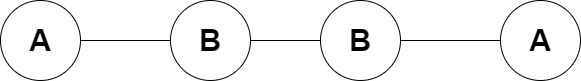
the border node will use graph_sum2 function as it has only 1 adjacent node and the rest will use graph_sum3 function .

In [ ]:
graph_input = copy.deepcopy(primary_split)
for row in range(len(primary_split)):
    sequence = primary_split[row]
    graph_input[row][0]=graph_sum2(sequence[0],sequence[1])
    graph_input[row][len(sequence)-1]=graph_sum2(sequence[len(sequence)-1],sequence[len(sequence)-2])
    for col in range(1,len(sequence)-1):
        graph_input[row][col] = graph_sum3(sequence[col-1],sequence[col],sequence[col+1])
        
graph_input[0:5]

In [ ]:
#for test data
graph_input_test1 = copy.deepcopy(primary_split_test1)
temp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for row in range(len(primary_split_test1)):
    sequence1 = primary_split_test1[row]
    if len(sequence1)>1:
        graph_input_test1[row][0]=graph_sum2(sequence1[0],sequence1[1])
        graph_input_test1[row][len(sequence1)-1]=graph_sum2(sequence1[len(sequence1)-1],sequence1[len(sequence1)-2])
        for col in range(1,len(sequence1)-1):
            graph_input_test1[row][col] = graph_sum3(sequence1[col-1],sequence1[col],sequence1[col+1])
    else:
        graph_input_test1[row][0]=graph_sum2(sequence1[0],temp)
        
graph_input_test1[0:5]

Make the secondary structure in a array of data using targetY function .

In [ ]:
def targetY(data_list):
    Y = []
    for i in range(len(data_list)):
        for j  in range(len(data_list[i])):
            Y.append(data_list[i][j])
    return Y

In [ ]:
y_label = targetY(secondary_split)
y_label_test1 = targetY(secondary_split_test1)

In [ ]:
print(len(y_label))
print(y_label[0:5])

In [ ]:
print(len(y_label_test1))
print(y_label_test1[0:5])

The data feature is formed using the window_padding_data function. This function will accept the size of the sliding window and sequence of the primary structure of the protein. In this function features will be processed such as adding padding 0 at the beginning and end and taking the features of the results of windowing so that the output data can be directly trained on the SVM model

In [ ]:
def window_padding_data(size, sequence):
    num = int(size/2)
    #print("initial :",sequence[0])
    #print("")
    zeros = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    for i in range(len(sequence)):
        for j in range(num):
            sequence[i].append(zeros)
            sequence[i].insert(0, zeros)
            #print(sequence[i])
            #print("")
            
    X = []
    temp = []

    for k in range(len(sequence)):
        #print(sequence[k])
        for l in range(len(sequence[k])-(size-1)):
            temp = sequence[k][l:l+size]
           # print(temp)
            X.append(temp)
            temp = []

    return X

In [ ]:
X = window_padding_data(11,graph_input)
print(len(X))
X[0:5]

In [ ]:
X_test1 = window_padding_data(11,graph_input_test1)
print(len(X_test1))
X_test1[0:5]

Before being entered into the Scikit-Learn SVM model, the data is reshape to follow the input size of the model. The data is reshaped to the length of X(primary structure) times multiplied by 220 (x window size and 20 orthogonal encoding sizes.)

In [ ]:
np.set_printoptions(threshold=np.inf)
X = np.array(X)
y_label = np.array(y_label)
X = X.reshape(len(X),11*20)
print(X[0:5])
print("X_train length :",len(X))
print("y_label length :",len(y_label))

In [ ]:
X_test1 = np.array(X_test1)
y_label_test1 = np.array(y_label_test1)
X_test1 = X_test1.reshape(len(X_test1),11*20)
print(X_test1[0:5])
print("X_train length :",len(X_test1))
print("y_label length :",len(y_label_test1))

Data is split into training and testing data. Next will be calculated with SVM and see the Classification Report

In [ ]:
#split the dataset into train set and test set
#X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size = 0.20,random_state=54)

In [ ]:
X_train = X
y_train = y_label
X_test = X_test1
y_test = y_label_test1

# Optimise the Hyper parameter

In [ ]:
# defining parameter range 
#param_grid = {'C': [0.1, 1, 10, 100, 1000],  
#              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
#              'kernel': ['rbf','linear','poly','sigmoid']}  
#  
#grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
# 
# fitting the model for grid search 
#grid.fit(X_train, y_train) 

In [ ]:
# print best parameter after tuning 
#print(grid.best_params_) 
# 
# print how our model looks after hyper-parameter tuning 
#print(grid.best_estimator_)

In [ ]:
#grid_predictions = grid.predict(X_test) 
#  
# print classification report 
#print(classification_report(y_test, grid_predictions)) 

In [ ]:
dictp = {'C':0,'gamma':0,'kernel':"none",'accuracy':0,'i':0}

In [ ]:
#for i in range(101):
#    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size = 0.20,random_state=i)
# defining parameter range 
#param_grid = {'C': [0.1, 1, 10, 100, 1000],  
#              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
#              'kernel': ['rbf','linear','poly','sigmoid']}  

#grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

# fitting the model for grid search 
#grid.fit(X_train, y_train) 

# print best parameter after tuning 
#print(grid.best_params_) 
# 
# print how our model looks after hyper-parameter tuning 
#print(grid.best_estimator_)

#grid_predictions = grid.predict(X_test) 
#  
# print classification report 
#print(classification_report(y_test, grid_predictions)) 
    #acu = accuracy_score(y_test,grid_predictions)*100
    #if dictp['accuracy']<acu:
        #dictp['accuracy']=acu
        #dictp['kernel']=grid.best_estimator['kernel']
        #dictp['gamma']=grid.best_estimator_['gamma']
        #dictp['C']=grid.best_estimator_['C']
        #dictp['i']=i
        
#print("i : ",dictp['i']," C : ",dictp['C']," gamma : ",dictp['gamma']," kernel : ",dictp['kernel']," accuracy : ",dictp['accuracy'])

# Use the SVM to find the classification

In [ ]:
#for i in range(1,101):
#    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size = 0.20,random_state=i)
#svc = SVC(kernel='rbf', gamma = 0.1, C=1.5)
#svc.fit(X_train, y_train)
#y_pred = svc.predict(X_test)
#y_true = y_test
#    print("i = ",i,"acc = ",metrics.accuracy_score(y_test, y_pred))
#print("Accuracy = ",metrics.accuracy_score(y_test, y_pred)*100)
#print(classification_report(y_true,y_pred))